# Loan Approval Prediction
# Decision Tree

In [63]:
import os
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, f1_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate, StratifiedKFold
import matplotlib.pyplot as plt



Loading Configuration

In [64]:
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)

DATA_DIR = Path(cfg["data_dir"]).expanduser()
FILENAME = cfg["filename"]
RANDOM_SEED = cfg["random_seed"]

Data preparation

In [65]:
df = pd.read_csv(os.path.join(DATA_DIR, FILENAME))

In [66]:
# split columns into numerical and categorical
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# remove target column from numerical columns
numerical_cols.remove('loan_status')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [67]:
# convert all categorical values to lowercase
for col in categorical_cols:
    df[col] = df[col].str.lower()

In [68]:
# fill missing values with median for numerical columns (robust to outliers)
df['person_emp_length'] = df['person_emp_length'].fillna((df['person_emp_length'].median()))
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

In [69]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,rent,123.0,personal,d,35000,16.02,1,0.59,y,3
1,21,9600,own,5.0,education,b,1000,11.14,0,0.10,n,2
2,25,9600,mortgage,1.0,medical,c,5500,12.87,1,0.57,n,3
3,23,65500,rent,4.0,medical,c,35000,15.23,1,0.53,n,2
4,24,54400,rent,8.0,medical,c,35000,14.27,1,0.55,y,4


Split data to train, val, test (60, 20, 20)

In [70]:
# Split
X_train_full, X_test = train_test_split(df, test_size=0.2, shuffle=True, 
                                        stratify=df['loan_status'], random_state=RANDOM_SEED)
X_train, X_val = train_test_split(X_train_full, test_size=0.25, shuffle=True,
                                  stratify=X_train_full['loan_status'], random_state=RANDOM_SEED) 

# reset index
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# separate target
y_train = X_train['loan_status'].values
y_val = X_val['loan_status'].values
y_test = X_test['loan_status'].values

X_train = X_train.drop(columns=['loan_status'])
X_val = X_val.drop(columns=['loan_status'])
X_test = X_test.drop(columns=['loan_status'])


In [71]:
# check data lengths
print(len(X_train), len(X_val), len(X_test))


19548 6516 6517


In [72]:
# check mean is same for y_train, y_val, y_test
print(y_train.mean(), y_val.mean(), y_test.mean())


0.21818088807039082 0.21807857581338244 0.21819855761853613


In [73]:

def build_preprocessor(categorical_cols, numerical_cols, use_log1p=False, use_scaler=False, handle_unknown='ignore'):
    transformers = [
        ('cat', OneHotEncoder(handle_unknown=handle_unknown), categorical_cols)
    ]

    # numeric
    if use_log1p or use_scaler:
        steps = []
        if use_log1p:
            steps.append(('log1p', FunctionTransformer(np.log1p)))
        if use_scaler:
            steps.append(('scaler', StandardScaler()))
        numeric_pipeline = Pipeline(steps)
        transformers.append(('num', numeric_pipeline, numerical_cols))
    else:
        transformers.append(('num', 'passthrough', numerical_cols))

    return ColumnTransformer(transformers)


def build_dt_pipeline(preprocessor, class_weight=None, random_state=RANDOM_SEED, 
                      max_depth=None, min_samples_leaf=1):
    # Construct a DecisionTreeClassifier pipeline given a preprocessor
    return Pipeline([
        ('preprocessor', preprocessor),
        ('clf', DecisionTreeClassifier(class_weight=class_weight, max_depth=max_depth,
                                       min_samples_leaf=min_samples_leaf,
                                       random_state=random_state))
    ])

In [74]:
def evaluate_model(model, X, y_true, threshold=0.5, experiment="", printOut=True, model_name=""):
    y_pred = model.predict_proba(X)[:, 1]
    y_pred_th = (y_pred >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred_th)
    conf_matrix = confusion_matrix(y_true, y_pred_th)
    precision = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    f1 = f1_score(y_true, y_pred_th)
    roc_auc = roc_auc_score(y_true  , y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    if printOut:
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("ROC AUC:", roc_auc)
        print("Confusion Matrix:\n", conf_matrix)

    result = {
        "model": model_name,
        "experiment": experiment,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "fpr": fpr,
        "tpr": tpr,
        "confusion_matrix": conf_matrix,
        "threshold": threshold
    }

    return result


In [75]:
arr_experiment_results = []

## E2-1 Experiment 2-1
Decision Tree, Baseline

In [76]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=False,
    use_scaler=False
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight=None
)

In [77]:
e21_model = model.fit(X_train, y_train)

r = evaluate_model(e21_model, X_val, y_val, 
                   experiment="E2-1", model_name="Decision Tree")
arr_experiment_results.append(r)

Accuracy: 0.8850521792510743
Precision: 0.7267206477732794
Recall: 0.7579169598874033
F1 Score: 0.7419910437478471
ROC AUC: 0.8392136320536133
Confusion Matrix:
 [[4690  405]
 [ 344 1077]]


In [78]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e21_model['clf'].feature_importances_.shape[0])


Transformed feature count: 26
Coefficient count: 26


## E2-2. Experiment 2-2
Decision Tree, with class_balance, because the target is imbalance.

In [79]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=False,
    use_scaler=False
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced'
)

In [80]:
e22_model = model.fit(X_train, y_train)

r = evaluate_model(e22_model, X_val, y_val, 
                   experiment="E2-2", model_name="Decision Tree")
arr_experiment_results.append(r)

Accuracy: 0.8833640270104358
Precision: 0.726525017135024
Recall: 0.7459535538353272
F1 Score: 0.7361111111111112
ROC AUC: 0.83382074158891
Confusion Matrix:
 [[4696  399]
 [ 361 1060]]


In [81]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e21_model['clf'].feature_importances_.shape[0])


Transformed feature count: 26
Coefficient count: 26


## E2-3. Experiment 2-3
Decision Tree, with class_balance and log1p transformation

In [82]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=True,
    use_scaler=False
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced'
)

In [83]:
e23_model = model.fit(X_train, y_train)

r = evaluate_model(e23_model, X_val, y_val, 
                   experiment="E2-3", model_name="Decision Tree")
arr_experiment_results.append(r)

Accuracy: 0.8848987108655617
Precision: 0.7321799307958478
Recall: 0.7445460942997889
F1 Score: 0.73831123517097
ROC AUC: 0.8342946369438101
Confusion Matrix:
 [[4708  387]
 [ 363 1058]]


In [84]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e23_model['clf'].feature_importances_.shape[0])


Transformed feature count: 26
Coefficient count: 26


## E2-4. Experiment 2-4
Decision Tree, with class_balance and log1p transformation, StandardScaler

In [85]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=True,
    use_scaler=True
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced'
)

In [86]:
e24_model = model.fit(X_train, y_train)

r = evaluate_model(e24_model, X_val, y_val, 
                   experiment="E2-4", model_name="Decision Tree")
arr_experiment_results.append(r)

Accuracy: 0.8848987108655617
Precision: 0.7321799307958478
Recall: 0.7445460942997889
F1 Score: 0.73831123517097
ROC AUC: 0.8342946369438101
Confusion Matrix:
 [[4708  387]
 [ 363 1058]]


In [87]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e24_model['clf'].feature_importances_.shape[0])

Transformed feature count: 26
Coefficient count: 26


## E2-5. Experiment 2-5
Decision Tree, with class_balance and log1p transformation, StandardScaler, Feature Engineering

In [88]:
# add feature engineering
df['loan_to_income'] = df['loan_amnt'] / df['person_income']
df['income_per_age'] = df['person_income'] / df['person_age']
df['credit_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
df['emp_stability'] = df['person_emp_length'] / df['person_age']
df['risk_index'] = df['loan_int_rate'] * df['loan_percent_income']

In [89]:
# split columns into numerical and categorical
numerical_cols_ext = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# remove target column from numerical columns
numerical_cols_ext.remove('loan_status')
categorical_cols_ext = df.select_dtypes(include=['object']).columns.tolist()

In [90]:
# Split
X_train_full_ext, X_test_ext = train_test_split(df, test_size=0.2, shuffle=True, 
                                        stratify=df['loan_status'], random_state=RANDOM_SEED)
X_train_ext, X_val_ext = train_test_split(X_train_full_ext, test_size=0.25, shuffle=True,
                                  stratify=X_train_full_ext['loan_status'], random_state=RANDOM_SEED) 

# reset index
X_train_ext = X_train_ext.reset_index(drop=True)
X_val_ext = X_val_ext.reset_index(drop=True)
X_test_ext = X_test_ext.reset_index(drop=True)

# separate target
y_train_ext = X_train_ext['loan_status'].values
y_val_ext = X_val_ext['loan_status'].values
y_test_ext = X_test_ext['loan_status'].values

X_train_ext = X_train_ext.drop(columns=['loan_status'])
X_val_ext = X_val_ext.drop(columns=['loan_status'])
X_test_ext = X_test_ext.drop(columns=['loan_status'])


In [91]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols_ext,
    numerical_cols=numerical_cols_ext,
    use_log1p=True,
    use_scaler=True
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced'
)

In [92]:
e25_model = model.fit(X_train_ext, y_train_ext)

r = evaluate_model(e25_model, X_val_ext, y_val_ext, 
                   experiment="E2-5", model_name="Decision Tree")
arr_experiment_results.append(r)

Accuracy: 0.8898096992019644
Precision: 0.7512508934953538
Recall: 0.7396199859254047
F1 Score: 0.7453900709219858
ROC AUC: 0.8356588644052931
Confusion Matrix:
 [[4747  348]
 [ 370 1051]]


In [93]:
# check feature count matches coefficient count, to make sure no mismatch
X_transformed = preprocessor.transform(X_train_ext)
print("Transformed feature count:", X_transformed.shape[1])
print("Coefficient count:", e25_model['clf'].feature_importances_.shape[0])

Transformed feature count: 31
Coefficient count: 31


In [94]:
pd.DataFrame(arr_experiment_results)[['experiment', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]


,experiment,accuracy,precision,recall,f1_score,roc_auc
0,E2-1,0.885052,0.726721,0.757917,0.741991,0.839214
1,E2-2,0.883364,0.726525,0.745954,0.736111,0.833821
2,E2-3,0.884899,0.732180,0.744546,0.738311,0.834295
3,E2-4,0.884899,0.732180,0.744546,0.738311,0.834295
4,E2-5,0.889810,0.751251,0.739620,0.745390,0.835659


## E2-6. Experiment 2-6
Decision Tree, with class_balance, Feature Engineering

In [95]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols_ext,
    numerical_cols=numerical_cols_ext,
    use_log1p=False,
    use_scaler=False
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight='balanced'
)

In [96]:
e26_model = model.fit(X_train_ext, y_train_ext)

r = evaluate_model(e26_model, X_val_ext, y_val_ext, 
                   experiment="E2-6", model_name="Decision Tree")
arr_experiment_results.append(r)

Accuracy: 0.8891958256599141
Precision: 0.7498213009292352
Recall: 0.7382125263898663
F1 Score: 0.7439716312056738
ROC AUC: 0.8347588637837458
Confusion Matrix:
 [[4745  350]
 [ 372 1049]]


## E2-7. Experiment 2-7
Decision Tree, with Feature Engineering only

In [97]:
# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols_ext,
    numerical_cols=numerical_cols_ext,
    use_log1p=False,
    use_scaler=False
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight=None
)

In [98]:
e27_model = model.fit(X_train_ext, y_train_ext)

r = evaluate_model(e27_model, X_val_ext, y_val_ext, 
                   experiment="E2-7", model_name="Decision Tree")
arr_experiment_results.append(r)

Accuracy: 0.8845917740945365
Precision: 0.7277059223961879
Recall: 0.7522871217452498
F1 Score: 0.7397923875432526
ROC AUC: 0.836889390116982
Confusion Matrix:
 [[4695  400]
 [ 352 1069]]


Experiment results

In [99]:
df_exp_res = pd.DataFrame(arr_experiment_results)

df_exp_res.round(3)

,model,experiment,accuracy,precision,recall,f1_score,roc_auc,fpr,tpr,confusion_matrix,threshold
0,Decision Tree,E2-1,0.885,0.727,0.758,0.742,0.839,"[0.0, 0.07948969578017664, 1.0]","[0.0, 0.7579169598874033, 1.0]","[[4690, 405], [344, 1077]]",0.5
1,Decision Tree,E2-2,0.883,0.727,0.746,0.736,0.834,"[0.0, 0.07831207065750737, 1.0]","[0.0, 0.7459535538353272, 1.0]","[[4696, 399], [361, 1060]]",0.5
2,Decision Tree,E2-3,0.885,0.732,0.745,0.738,0.834,"[0.0, 0.0759568204121688, 1.0]","[0.0, 0.7445460942997889, 1.0]","[[4708, 387], [363, 1058]]",0.5
3,Decision Tree,E2-4,0.885,0.732,0.745,0.738,0.834,"[0.0, 0.0759568204121688, 1.0]","[0.0, 0.7445460942997889, 1.0]","[[4708, 387], [363, 1058]]",0.5
4,Decision Tree,E2-5,0.890,0.751,0.740,0.745,0.836,"[0.0, 0.06830225711481845, 1.0]","[0.0, 0.7396199859254047, 1.0]","[[4747, 348], [370, 1051]]",0.5
5,Decision Tree,E2-6,0.889,0.750,0.738,0.744,0.835,"[0.0, 0.06869479882237488, 1.0]","[0.0, 0.7382125263898663, 1.0]","[[4745, 350], [372, 1049]]",0.5
6,Decision Tree,E2-7,0.885,0.728,0.752,0.740,0.837,"[0.0, 0.07850834151128558, 1.0]","[0.0, 0.7522871217452498, 1.0]","[[4695, 400], [352, 1069]]",0.5


In [100]:
df_exp_res.columns

Index(['model', 'experiment', 'accuracy', 'precision', 'recall', 'f1_score',
       'roc_auc', 'fpr', 'tpr', 'confusion_matrix', 'threshold'],
      dtype='object')

In [101]:
df_exp_res.describe().round(3)

,accuracy,precision,recall,f1_score,roc_auc,threshold
count,7.000,7.000,7.000,7.000,7.000,7.0
mean,0.886,0.735,0.746,0.741,0.836,0.5
std,0.002,0.011,0.007,0.003,0.002,0.0
min,0.883,0.727,0.738,0.736,0.834,0.5
25%,0.885,0.727,0.742,0.738,0.834,0.5
50%,0.885,0.732,0.745,0.740,0.835,0.5
75%,0.887,0.741,0.749,0.743,0.836,0.5
max,0.890,0.751,0.758,0.745,0.839,0.5


From this experiments, it can be conclude:
Decision Tree performance remains nearly constant across preprocessing steps.

The baseline model (E2-1) achieves the best recall (0.7579) and highest ROC-AUC (0.8392).
Class balancing, log transformation, and scaling do not improve results, confirming the tree’s scale-invariant and nonlinear nature.

Using E2-1 as Decision Tree best model.



## E2-8. Experiment 2-8
Decision Tree without data transformation, scaling and feature engineering. 

Tuning Hyperparameter

### Find Best max_depth

In [102]:
arr_max_depth = [1,2,3,4,5, 6, 7, 8, 9, 10]

max_depth_results = []

for max_depth in arr_max_depth:
    # Preprocess and model via helpers
    preprocessor = build_preprocessor(
        categorical_cols=categorical_cols,
        numerical_cols=numerical_cols,
        use_log1p=False,
        use_scaler=False
    )

    model = build_dt_pipeline(
        preprocessor=preprocessor,
        class_weight=None,
        max_depth=max_depth
    )

    m = model.fit(X_train, y_train)

    r = evaluate_model(m, X_val, y_val, 
                       experiment=f"E2-8_MD_{max_depth}", model_name="Decision Tree", printOut=False)
    max_depth_results.append(r)
    #print(f"Completed evaluation for max_depth={max_depth}")

df_max_depth_results = pd.DataFrame(max_depth_results)




In [103]:
df_max_depth_results

,model,experiment,accuracy,precision,recall,f1_score,roc_auc,fpr,tpr,confusion_matrix,threshold
0,Decision Tree,E2-8_MD_1,0.833180,0.732591,0.370162,0.491819,0.666239,"[0.0, 0.03768400392541708, 1.0]","[0.0, 0.3701618578465869, 1.0]","[[4903, 192], [895, 526]]",0.5
1,Decision Tree,E2-8_MD_2,0.848220,0.666410,0.608726,0.636263,0.792132,"[0.0, 0.0, 0.08498527968596663, 0.122669283611...","[0.0, 0.31738212526389864, 0.6087262491203378,...","[[4662, 433], [556, 865]]",0.5
2,Decision Tree,E2-8_MD_3,0.875077,0.738788,0.660802,0.697623,0.828662,"[0.0, 0.0, 0.004514229636898921, 0.06516192345...","[0.0, 0.32934553131597466, 0.3912737508796622,...","[[4763, 332], [482, 939]]",0.5
3,Decision Tree,E2-8_MD_4,0.888735,0.870213,0.575651,0.692927,0.857179,"[0.0, 0.0, 0.011579980372914623, 0.01570166830...","[0.0, 0.3842364532019704, 0.5130190007037297, ...","[[4973, 122], [603, 818]]",0.5
4,Decision Tree,E2-8_MD_5,0.902548,0.990025,0.558761,0.714350,0.873882,"[0.0, 0.00019627085377821394, 0.00117762512266...","[0.0, 0.49261083743842365, 0.5404644616467277,...","[[5087, 8], [627, 794]]",0.5
5,Decision Tree,E2-8_MD_6,0.917281,0.944556,0.659395,0.776627,0.879743,"[0.0, 0.00019627085377821394, 0.00019627085377...","[0.0, 0.5411681914144968, 0.5587614356087263, ...","[[5040, 55], [484, 937]]",0.5
6,Decision Tree,E2-8_MD_7,0.922959,0.967447,0.669247,0.791181,0.892526,"[0.0, 0.0009813542688910696, 0.003532875368007...","[0.0, 0.597466572836031, 0.6432090077410274, 0...","[[5063, 32], [470, 951]]",0.5
7,Decision Tree,E2-8_MD_8,0.925875,0.970884,0.680507,0.800165,0.894907,"[0.0, 0.0013738959764474975, 0.001373895976447...","[0.0, 0.6206896551724138, 0.6460239268121042, ...","[[5066, 29], [454, 967]]",0.5
8,Decision Tree,E2-8_MD_9,0.925875,0.955340,0.692470,0.802938,0.894487,"[0.0, 0.001962708537782139, 0.0019627085377821...","[0.0, 0.657283603096411, 0.661505981703026, 0....","[[5049, 46], [437, 984]]",0.5
9,Decision Tree,E2-8_MD_10,0.925875,0.946667,0.699507,0.804533,0.893663,"[0.0, 0.0043179587831207065, 0.004710500490677...","[0.0, 0.673469387755102, 0.6748768472906403, 0...","[[5039, 56], [427, 994]]",0.5


In [104]:
df_max_depth_results[['experiment', 'precision', 'recall', 'roc_auc', 'f1_score']].round(3)

,experiment,precision,recall,roc_auc,f1_score
0,E2-8_MD_1,0.733,0.370,0.666,0.492
1,E2-8_MD_2,0.666,0.609,0.792,0.636
2,E2-8_MD_3,0.739,0.661,0.829,0.698
3,E2-8_MD_4,0.870,0.576,0.857,0.693
4,E2-8_MD_5,0.990,0.559,0.874,0.714
5,E2-8_MD_6,0.945,0.659,0.880,0.777
6,E2-8_MD_7,0.967,0.669,0.893,0.791
7,E2-8_MD_8,0.971,0.681,0.895,0.800
8,E2-8_MD_9,0.955,0.692,0.894,0.803
9,E2-8_MD_10,0.947,0.700,0.894,0.805


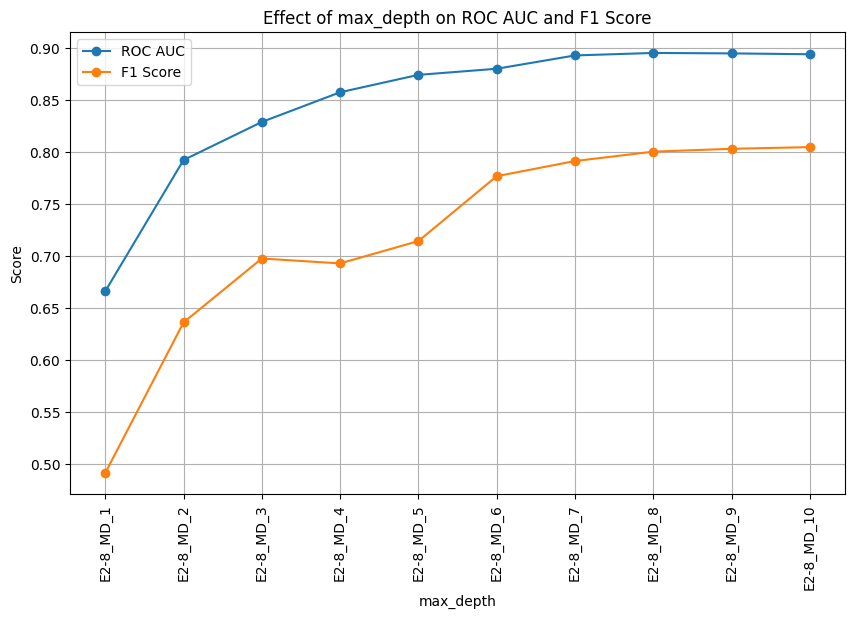

In [105]:
# plot max_depth vs ROC AUC and F1 Score
plt.figure(figsize=(10, 6))
plt.plot(df_max_depth_results['experiment'], df_max_depth_results['roc_auc'], marker='o')
plt.plot(df_max_depth_results['experiment'], df_max_depth_results['f1_score'], marker='o')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.title('Effect of max_depth on ROC AUC and F1 Score')
plt.legend(['ROC AUC', 'F1 Score'])
plt.grid(True)
plt.show()

Both ROC AUC and F1 Score improve as max_depth increases from 1 → 8. After max_depth=8, both metric flat (no significant improvement).

Choose max_depth 8. 



### Find best min_samples_leaf

In [106]:
arr_min_samples_leaf = [1, 5, 10, 15, 20, 100, 200, 500]

best_max_depth = 8
min_samples_leaf_results = []

for min_samples_leaf in arr_min_samples_leaf:
    # Preprocess and model via helpers
    preprocessor = build_preprocessor(
        categorical_cols=categorical_cols,
        numerical_cols=numerical_cols,
        use_log1p=False,
        use_scaler=False
    )

    model = build_dt_pipeline(
        preprocessor=preprocessor,
        class_weight=None,
        max_depth=best_max_depth,
        min_samples_leaf=min_samples_leaf
    )

    m = model.fit(X_train, y_train)

    r = evaluate_model(m, X_val, y_val, 
                       experiment=f"E2-8_MD_{best_max_depth}_MSL_{min_samples_leaf}", model_name="Decision Tree", printOut=False)
    min_samples_leaf_results.append(r)
    #print(f"Completed evaluation for min_samples_leaf={min_samples_leaf}")

df_min_samples_leaf_results = pd.DataFrame(min_samples_leaf_results)




In [107]:
df_min_samples_leaf_results

,model,experiment,accuracy,precision,recall,f1_score,roc_auc,fpr,tpr,confusion_matrix,threshold
0,Decision Tree,E2-8_MD_8_MSL_1,0.925875,0.970884,0.680507,0.800165,0.894907,"[0.0, 0.0013738959764474975, 0.001373895976447...","[0.0, 0.6206896551724138, 0.6460239268121042, ...","[[5066, 29], [454, 967]]",0.5
1,Decision Tree,E2-8_MD_8_MSL_5,0.924647,0.962227,0.681210,0.797693,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[5057, 38], [453, 968]]",0.5
2,Decision Tree,E2-8_MD_8_MSL_10,0.923112,0.961847,0.674173,0.792718,0.897986,"[0.0, 0.0005888125613346418, 0.000588812561334...","[0.0, 0.5911330049261084, 0.6164672765657987, ...","[[5057, 38], [463, 958]]",0.5
3,Decision Tree,E2-8_MD_8_MSL_15,0.921578,0.952286,0.674173,0.789452,0.901938,"[0.0, 0.0005888125613346418, 0.001373895976447...","[0.0, 0.5925404644616468, 0.5967628430682618, ...","[[5047, 48], [463, 958]]",0.5
4,Decision Tree,E2-8_MD_8_MSL_20,0.921424,0.939130,0.684025,0.791531,0.903369,"[0.0, 0.0005888125613346418, 0.000588812561334...","[0.0, 0.5847994370161858, 0.597466572836031, 0...","[[5032, 63], [449, 972]]",0.5
5,Decision Tree,E2-8_MD_8_MSL_100,0.908379,0.911178,0.642505,0.753611,0.901504,"[0.0, 0.00019627085377821394, 0.00078508341511...","[0.0, 0.4975369458128079, 0.5242786769880365, ...","[[5006, 89], [508, 913]]",0.5
6,Decision Tree,E2-8_MD_8_MSL_200,0.906077,0.912334,0.629838,0.745212,0.900117,"[0.0, 0.0, 0.0009813542688910696, 0.0041216879...","[0.0, 0.422237860661506, 0.47009148486981, 0.5...","[[5009, 86], [526, 895]]",0.5
7,Decision Tree,E2-8_MD_8_MSL_500,0.870319,0.820713,0.518649,0.635619,0.879003,"[0.0, 0.0, 0.019234543670264965, 0.03159960745...","[0.0, 0.31738212526389864, 0.45320197044334976...","[[4934, 161], [684, 737]]",0.5


In [108]:
df_min_samples_leaf_results[['experiment', 'precision', 'recall', 'roc_auc', 'f1_score']].round(3)

,experiment,precision,recall,roc_auc,f1_score
0,E2-8_MD_8_MSL_1,0.971,0.681,0.895,0.800
1,E2-8_MD_8_MSL_5,0.962,0.681,0.897,0.798
2,E2-8_MD_8_MSL_10,0.962,0.674,0.898,0.793
3,E2-8_MD_8_MSL_15,0.952,0.674,0.902,0.789
4,E2-8_MD_8_MSL_20,0.939,0.684,0.903,0.792
5,E2-8_MD_8_MSL_100,0.911,0.643,0.902,0.754
6,E2-8_MD_8_MSL_200,0.912,0.630,0.900,0.745
7,E2-8_MD_8_MSL_500,0.821,0.519,0.879,0.636


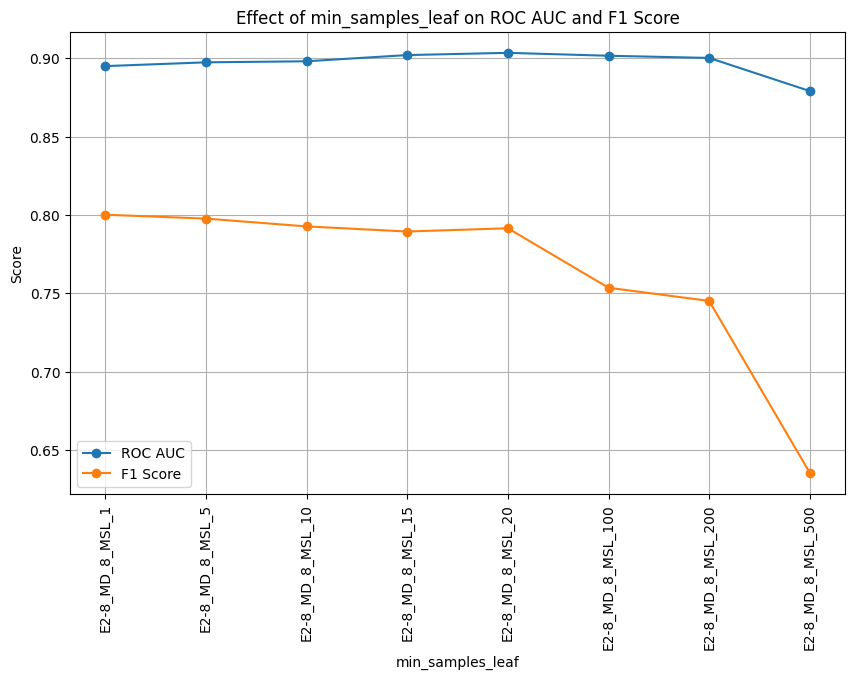

In [109]:
# plot min_samples_leaf vs ROC AUC and F1 Score
plt.figure(figsize=(10, 6))
plt.plot(df_min_samples_leaf_results['experiment'], df_min_samples_leaf_results['roc_auc'], marker='o')
plt.plot(df_min_samples_leaf_results['experiment'], df_min_samples_leaf_results['f1_score'], marker='o')
plt.xlabel('min_samples_leaf')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.title('Effect of min_samples_leaf on ROC AUC and F1 Score')
plt.legend(['ROC AUC', 'F1 Score'])
plt.grid(True)
plt.show()

In [110]:
best_min_samples_leaf = 5

Baseline E2-1:
- F1 score 0.742
- ROC AUC 0.839

Use max_depth=8 and min_samples_leaf=5:
- F1 score 0.797
- ROC AUC 0.897

### Cross validation

In [111]:
cv_results = []

X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = np.concatenate([y_train, y_val])


# Preprocess and model via helpers
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=False,
    use_scaler=False
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight=None,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf
)


# K-Fold (Stratified to maintain class balance)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Evaluate multiple metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv = cross_validate(model, X_full_train, y_full_train, cv=kf, scoring=scoring, n_jobs=-1)

#print(cv)
# calculate mean and std for each metric and add to cv_results
cv_mean = {
    'accuracy_mean': np.mean(cv['test_accuracy']),
    'accuracy_std': np.std(cv['test_accuracy']),
    'precision_mean': np.mean(cv['test_precision']),
    'precision_std': np.std(cv['test_precision']),
    'recall_mean': np.mean(cv['test_recall']),
    'recall_std': np.std(cv['test_recall']),
    'f1_mean': np.mean(cv['test_f1']),
    'f1_std': np.std(cv['test_f1']),
    'roc_auc_mean': np.mean(cv['test_roc_auc']),
    'roc_auc_std': np.std(cv['test_roc_auc']),
}

print('Accuracy Mean:', cv_mean['accuracy_mean'].round(3))
print('Accuracy Std:', cv_mean['accuracy_std'].round(3))
print('')

print('Precision Mean:', cv_mean['precision_mean'].round(3))
print('Precision Std:', cv_mean['precision_std'].round(3))
print('')

print('Recall Mean:', cv_mean['recall_mean'].round(3))
print('Recall Std:', cv_mean['recall_std'].round(3))
print('')

print('F1 Mean:', cv_mean['f1_mean'].round(3))
print('F1 Std:', cv_mean['f1_std'].round(3))
print('')

print('ROC AUC Mean:', cv_mean['roc_auc_mean'].round(3))
print('ROC AUC Std:', cv_mean['roc_auc_std'].round(3))





Accuracy Mean: 0.927
Accuracy Std: 0.003

Precision Mean: 0.969
Precision Std: 0.007

Recall Mean: 0.69
Recall Std: 0.012

F1 Mean: 0.806
F1 Std: 0.009

ROC AUC Mean: 0.899
ROC AUC Std: 0.006


Base on cross validation it looks stable.

Train model for experiment E2-8 with max_depth=8 and min_samples_leaf=5

In [112]:
preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=False,
    use_scaler=False
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight=None,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf
)

e28_model = model.fit(X_train, y_train)

r = evaluate_model(e28_model, X_val, y_val, 
                   experiment=f"E28_DT_MD{best_max_depth}_MSL{best_min_samples_leaf}", model_name="Decision Tree", printOut=False)
arr_experiment_results.append(r)

Feature Importance

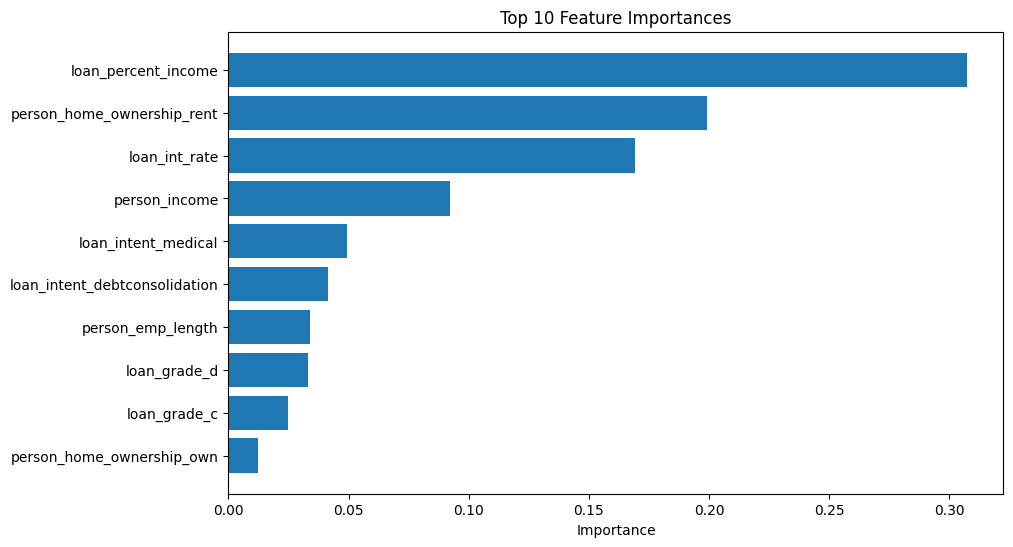

In [113]:

feature_names = (categorical_cols + numerical_cols)
importances = e28_model['clf'].feature_importances_

# Get feature names after one-hot encoding
ohe_feature_names = e28_model['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(ohe_feature_names) + numerical_cols

# Plot top 10 features
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## Find Best Threshold

In [114]:
thresholds = np.arange(0, 1.01, 0.01)

arr_threshold_results = []
for t in thresholds:
    r = evaluate_model(e28_model, X_val, y_val, threshold=t,
                    experiment=f"E9_DT_TH{t}", model_name="Decision Tree", printOut=False)
    arr_threshold_results.append(r)
    
#best_threshold = thresholds[np.argmax(arr_threshold_results)]

#print('Best threshold:', best_threshold)
#print('Best f1 score:', max(f1_scores))

In [115]:
arr_threshold_results

[{'model': 'Decision Tree',
  'experiment': 'E9_DT_TH0.0',
  'accuracy': 0.21807857581338244,
  'precision': 0.21807857581338244,
  'recall': 1.0,
  'f1_score': 0.3580697996724203,
  'roc_auc': 0.8973105644409975,
  'fpr': array([0.        , 0.00117763, 0.00117763, 0.00117763, 0.00117763,
         0.00176644, 0.00294406, 0.00549558, 0.00588813, 0.00588813,
         0.00628067, 0.00667321, 0.00745829, 0.00765456, 0.00765456,
         0.01275761, 0.01589794, 0.01609421, 0.01844946, 0.01903827,
         0.01943081, 0.02041217, 0.02158979, 0.03336605, 0.03395486,
         0.04474975, 0.04730128, 0.06241413, 0.10421982, 0.10500491,
         0.10834151, 0.18410206, 0.18763494, 0.62983317, 0.63022571,
         0.63395486, 0.64180569, 0.90107949, 0.91952895, 1.        ]),
  'tpr': array([0.        , 0.61576355, 0.64109782, 0.64180155, 0.64461647,
         0.64954258, 0.65376495, 0.67417312, 0.67628431, 0.6783955 ,
         0.6783955 , 0.67909923, 0.68121042, 0.68121042, 0.68191414,
         0.

In [116]:
df_th_results = pd.DataFrame(arr_threshold_results)
df_th_results

,model,experiment,accuracy,precision,recall,f1_score,roc_auc,fpr,tpr,confusion_matrix,threshold
0,Decision Tree,E9_DT_TH0.0,0.218079,0.218079,1.000000,0.358070,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[0, 5095], [0, 1421]]",0.00
1,Decision Tree,E9_DT_TH0.01,0.279619,0.231589,0.993666,0.375632,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[410, 4685], [9, 1412]]",0.01
2,Decision Tree,E9_DT_TH0.02,0.279619,0.231589,0.993666,0.375632,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[410, 4685], [9, 1412]]",0.02
3,Decision Tree,E9_DT_TH0.03,0.293432,0.234706,0.990852,0.379515,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[504, 4591], [13, 1408]]",0.03
4,Decision Tree,E9_DT_TH0.04,0.488336,0.293279,0.954961,0.448743,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[1825, 3270], [64, 1357]]",0.04
...,...,...,...,...,...,...,...,...,...,...,...
96,Decision Tree,E9_DT_TH0.96,0.920810,0.993457,0.641098,0.779299,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[5089, 6], [510, 911]]",0.96
97,Decision Tree,E9_DT_TH0.97,0.920810,0.993457,0.641098,0.779299,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[5089, 6], [510, 911]]",0.97
98,Decision Tree,E9_DT_TH0.98,0.920810,0.993457,0.641098,0.779299,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[5089, 6], [510, 911]]",0.98
99,Decision Tree,E9_DT_TH0.99,0.920810,0.993457,0.641098,0.779299,0.897311,"[0.0, 0.0011776251226692837, 0.001177625122669...","[0.0, 0.6157635467980296, 0.64109781843772, 0....","[[5089, 6], [510, 911]]",0.99


In [117]:
best_threshold = thresholds[np.argmax(df_th_results['f1_score'])]

print('Best threshold:', best_threshold)
print('Best precision:', df_th_results.loc[df_th_results['f1_score'].idxmax()]['precision'] )
print('Best recall:', df_th_results.loc[df_th_results['f1_score'].idxmax()]['recall'] )
print('Best f1 score:', max(df_th_results['f1_score']))
print('Best ROC AUC:', df_th_results.loc[df_th_results['f1_score'].idxmax()]['roc_auc'] )
print("Confusion Matrix:\n", df_th_results.loc[df_th_results['f1_score'].idxmax()]['confusion_matrix'] )

Best threshold: 0.62
Best precision: 0.9698189134808853
Best recall: 0.6783954961294862
Best f1 score: 0.798343685300207
Best ROC AUC: 0.8973105644409975
Confusion Matrix:
 [[5065   30]
 [ 457  964]]


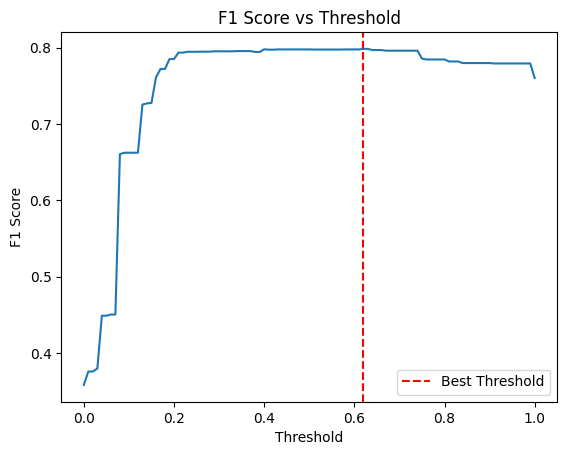

In [118]:
# plot f1 scores vs thresholds
plt.plot(df_th_results['threshold'], df_th_results['f1_score'])
# draw vertical line at best threshold
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.show()

In [119]:
# calculate precision and recall crossing
array_precision = df_th_results['precision'].values
array_recall = df_th_results['recall'].values

# threshold with precision cross recall
cross_threshold = 0.0
for i in range(len(thresholds)):
    if array_precision[i] >= array_recall[i]:
        cross_threshold = thresholds[i]
        print(f'Threshold Cross: {cross_threshold:.2f}, Precision: {array_precision[i]:.3f}, Recall: {array_recall[i]:.3f}')

        print('Cross threshold:', cross_threshold)
        print('Cross precision:', f"{array_precision[i]:.3f}" )
        print('Cross recall:', f"{array_recall[i]:.3f}" )
        print('Cross f1 score:', df_th_results.loc[i]['f1_score'] )
        print('Cross ROC AUC:', df_th_results.loc[i]['roc_auc'] )
        print("Cross Confusion Matrix:\n", df_th_results.loc[i]['confusion_matrix'] )

        break


Threshold Cross: 0.16, Precision: 0.771, Recall: 0.752
Cross threshold: 0.16
Cross precision: 0.771
Cross recall: 0.752
Cross f1 score: 0.7609547559672248
Cross ROC AUC: 0.8973105644409975
Cross Confusion Matrix:
 [[4777  318]
 [ 353 1068]]


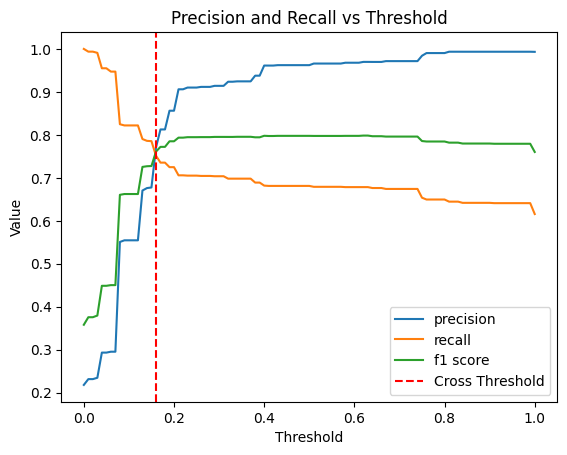

In [120]:
plt.plot(df_th_results['threshold'], df_th_results['precision'], label='precision')
plt.plot(df_th_results['threshold'], df_th_results['recall'], label='recall')  
plt.plot(df_th_results['threshold'], df_th_results['f1_score'], label='f1 score')
plt.axvline(x=cross_threshold, color='r', linestyle='--', label='Cross Threshold')
plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.show()

## Final Model Training with dataset (train+val)

The performance reported below is evaluated only on the test set, which was never used during model training or tuning.

Final model train using parameter max_depth=8 and min_samples_leaf=5 and threshold 0.16 and 0.62.

In [121]:
# combine train + val

X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = np.concatenate([y_train, y_val])

preprocessor = build_preprocessor(
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    use_log1p=False,
    use_scaler=False
)

model = build_dt_pipeline(
    preprocessor=preprocessor,
    class_weight=None,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf
)

final_model = model.fit(X_full_train, y_full_train)

# do with test dataset
r_th016 = evaluate_model(final_model, X_test, y_test, threshold=0.16,
                    experiment=f"E2-final", model_name="Decision Tree", printOut=False)

r_th062 = evaluate_model(final_model, X_test, y_test, threshold=0.62,
                    experiment=f"E2-final", model_name="Decision Tree", printOut=False)

#print(r_th071)
#print(r_th068)

In [122]:
print("threshold 0.16")
print('f1 score:', r_th016['f1_score'])
print('ROC AUC:', r_th016['roc_auc'])
print('precision:', r_th016['precision'])
print('recall:', r_th016['recall'])
print("Confusion Matrix:\n", r_th016['confusion_matrix'])
print()

print("threshold 0.62")
print('f1 score:', r_th062['f1_score'])
print('ROC AUC:', r_th062['roc_auc'])
print('precision:', r_th062['precision'])
print('recall:', r_th062['recall'])
print("Confusion Matrix:\n", r_th062['confusion_matrix'])

threshold 0.16
f1 score: 0.7680469036277024
ROC AUC: 0.8979692453785943
precision: 0.8018362662586075
recall: 0.7369901547116737
Confusion Matrix:
 [[4836  259]
 [ 374 1048]]

threshold 0.62
f1 score: 0.8103661044837516
ROC AUC: 0.8979692453785943
precision: 0.9762140733399405
recall: 0.6926863572433193
Confusion Matrix:
 [[5071   24]
 [ 437  985]]


In [123]:
# combine r_th071 and r_th068 into a single DataFrame
df_final_results = pd.DataFrame([r_th016, r_th062])

df_final_results[['experiment', 'threshold', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(3)

,experiment,threshold,accuracy,precision,recall,f1_score,roc_auc
0,E2-final,0.16,0.903,0.802,0.737,0.768,0.898
1,E2-final,0.62,0.929,0.976,0.693,0.810,0.898


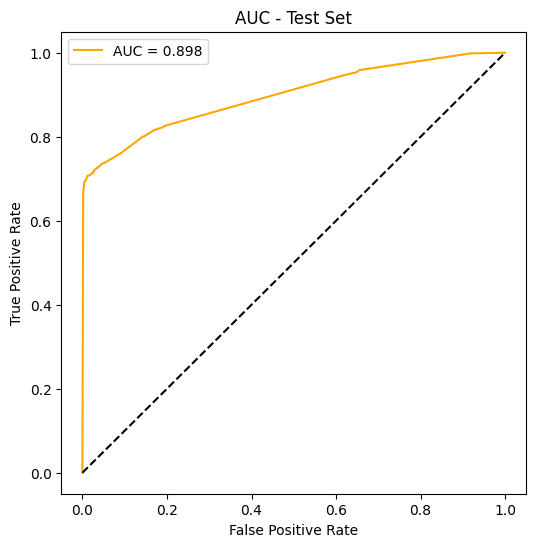

In [124]:
fpr016, tpr016 = df_final_results.iloc[0]['fpr'], df_final_results.iloc[0]['tpr']
fpr062, tpr062 = df_final_results.iloc[1]['fpr'], df_final_results.iloc[1]['tpr']
roc_auc016 = auc(fpr016, tpr016)
roc_auc062 = auc(fpr062, tpr062)

plt.figure(figsize=(6,6))
#plt.plot(fpr016, tpr016, label=f'AUC = {roc_auc016:.3f}', color='blue')
plt.plot(fpr062, tpr062, label=f'AUC = {roc_auc062:.3f}', color='orange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC - Test Set')
plt.legend()
plt.show()


Decision Tree achieved 0.81 F1 and 0.89 ROC AUC with max_depth=8, min_samples_leaf=5, threshold=0.62. No gain from feature scaling or transformation.

Threshold: 0.16
- f1 score: 0.768
- ROC AUC: 0.897
- precision: 0.801
- recall: 0.736

Threshold: 0.62
- f1 score: 0.810
- ROC AUC: 0.897
- precision: 0.976
- recall: 0.692

From this result comparing threshold 0.16 & 0.62:
- F1 score is higher with threshold 0.62
- With threshold 0.62, precision high and recall a little lower, it means model ability to capture loan approve is less than using threshold 0.16. 
- Choose 0.62 if precision is priority (correctness of approvals is priority, to avoiding approving risky loans)
- Choose 0.16 if ability to capture the loan approve, is priority. To capture more potential good loans, even if a few risky ones slip in.


